# Question 1
> Summarize for us the goal of this project and how machine learning is useful in trying to accomplish it. As part of your answer, give some background on the dataset and how it can be used to answer the project question. Were there any outliers in the data when you got it, and how did you handle those?  [relevant rubric items: “data exploration”, “outlier investigation”]

This project aims to build an efficient machine learning algorithm to programatically detect potential persons of interest within data. The model is expected to make the best use of available features withing Enron Dataset as well as creating new features to predict the poi from the available features. 

Enron data has 146 data points, 18 of which belong POIs. Each datapoint has 14 features. Features cover a wide variety of data from financial attributes like salary, bonuses, payments to email statistics like emails to POI, and emails from POI. 

Dataset has one outlier data which belongs to an entry named "TOTAL". This entry clearly points to the subtotal for the entire dataset, and thereby should be discarded. Discaridng this entry leaves 18 POI and 127 non-POI entries. With 12.4% POI within dataset, data is skewed towards non-POIs. We should keep an eye on this insight during score extractions from models. Assuming we are primarily concerned with detecting as many POIs as possible, recall will be the primary score we will be looking to.

# Question 2
> What features did you end up using in your POI identifier, and what selection process did you use to pick them? Did you have to do any scaling? Why or why not? As part of the assignment, you should attempt to engineer your own feature that does not come ready-made in the dataset -- explain what feature you tried to make, and the rationale behind it. (You do not necessarily have to use it in the final analysis, only engineer and test it.) In your feature selection step, if you used an algorithm like a decision tree, please also give the feature importances of the features that you use, and if you used an automated feature selection function like SelectKBest, please report the feature scores and reasons for your choice of parameter values.  [relevant rubric items: “create new features”, “intelligently select features”, “properly scale features”]

Since the number of variables was within acecptable range, I started with the full set to decide on an model parameters. Later on I was planning on reducing number of parameters. First approach was using Tree Classifier parameter weights extracted from trained classifier usign full variable set. 

#### Here is list of parameters with non-zero values:

|Parameter|Weight|
|---|---|
|from_poi_ratio|0.410935|
|total_stock_value|0.188715|
|bonus|0.124453|
|shared_receipt_with_poi|0.106765|
|to_messages|0.105462|
|restricted_stock|0.063670|

My second approach was finding variables having > 0.9 correlation with poi and >0.9 correlation with those that have >0.9 correlation with poi, and so forth until a depth value. I used a depth of 1. 

I did not use any scaling, knowing scaling would have no effect on tree classifiers which I believed will be optimal predictors for this project. However, I filled missing values each with a **GaussianNB** predictor that used all parameters other than the original one plus the **poi** parameter. Later on the predictions from **GaussianNB** predictor are used to fill missing values.

I created two new variables, one for **ratio of mails received from POIs**, and the other for **ratio of mail sent to POIs**. I believe the numbers of mails sent to POI or received thereof would not give meaningful info. SOme might be sending too many emails or too few emails overall. In this case, having the ratio for their POI related emails would provide better insight.

# Question 3
> What algorithm did you end up using? What other one(s) did you try? How did model performance differ between algorithms?  [relevant rubric item: “pick an algorithm”]

I decided to try all classifiers including linear models with an added rounding layer. From Linear models GaussianNB, and Linear Regression, the predictors are used without parameter tuning, since they dont have parameter tuning. For Lasso and other regular classifiers, I used a set of parameters with Grid Search. All scores listed below belong to best parameter combinations.

#### Full Feature Set Results:

Classifier|Accuracy|Precision|Recall|F1 Score|F2 Score
---|---|---|---|---|---
GaussianNB|0.886|0.33|0.25|0.286|0.263
Linear Regression|0.864|0.25|0.25|0.25|0.25
Lasso|0.8636363636363636|0.25|0.25|0.25|0.25
SVC|0.9090909090909091|0.0|0.0|0.0|0.0
DecisionTreeClassifier|0.841|0.2|0.25|0.22|0.238
RandomForestClassifier|0.932|1.0|0.25|0.4|0.294

#### DecisionTreeClassifier Weights Feature Selector

Classifier|Accuracy|Precision|Recall|F1 Score|F2 Score
---|---|---|---|---|---
GaussianNB|0.886|0.4|0.5|0.444|0.476
Linear Regression|0.91|0.5|0.25|0.333|0.278
Lasso|0.91|0.5|0.25|0.333|0.278
SVC|0.91|0.0|0.0|0.0|0.0
DecisionTreeClassifier|0.886|0.4|0.5|0.444|0.476
RandomForestClassifier|0.864|0.0|0.0|0.0|0.0

#### Correlation (depth = 1) Results:

Classifier|Accuracy|Precision|Recall|F1 Score|F2 Score
---|---|---|---|---|---
GaussianNB|0.864|0.25|0.25|0.25|0.25
Linear Regression|0.886|0.333|0.25|0.2865|0.263
Lasso|0.91|0.5|0.25|0.333|0.278
SVC|0.91|0.0|0.0|0.0|0.0
DecisionTreeClassifier|0.91|0.5|1.0|0.67|0.833
RandomForestClassifier|0.977|1.0|0.75|0.857|0.789



**Correlation @ Depth = 1** gave best results with highest Recall score of DecisionTreeClassifier (100%) and highest Precision of RandomForestClassifier (100%). 

Since finding all POIs is more important than precisely finding correct POIs, the primary score is Recall. Therefore, I decided to go with **DecisionTreeClassifier**.

# Question 4
> What does it mean to tune the parameters of an algorithm, and what can happen if you don’t do this well?  How did you tune the parameters of your particular algorithm? What parameters did you tune? (Some algorithms do not have parameters that you need to tune -- if this is the case for the one you picked, identify and briefly explain how you would have done it for the model that was not your final choice or a different model that does utilize parameter tuning, e.g. a decision tree classifier).  [relevant rubric items: “discuss parameter tuning”, “tune the algorithm”]

Classifiers have a lot of parameters in order to decide their behaviors with fitting data and classifiying input. Each data will need different set of parameter values to classify input the most efficiently. Parameter tuning is trying to find this best parameters or getting close enough.

For this project I went through list of parameters available for tuning for each classifier. Each classifier is then wrapped with GridSearch alongside with this parameter ranges. Gridsearch, then tries all combinations of these parameter valu lists, and returns the best predictor configuration.

At the end of parameter tuning I decided to go with **DecisionTreeClassifier**. The best parameters found with this classifier are as below:

    DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None
        max_features=None, max_leaf_nodes=None,
        min_impurity_split=1e-07, min_samples_leaf=5,
        min_samples_split=2, min_weight_fraction_leaf=0.0,
        presort=False, random_state=0, splitter='best')

# Question 5
> What is validation, and what’s a classic mistake you can make if you do it wrong? How did you validate your analysis?  [relevant rubric items: “discuss validation”, “validation strategy”]

Validation is testing the classifier / model built for the purpose or classifying new data. To do this, original data should be split into two groups: **train** and **test**

Train data is used to build model/classifier. Test data is used to validate if the model behaves as expected. Test data is expected to be completely new to the classifier at the time testing. Test data can also be split into validation and test for bling testing. But in this project we only split data into train and test.

In model building stage of this project we also split data into train and test. We first fitted out classifiers with train dataset. Later on we evaluated our classifiers based on test data. 

However this type of evaluation is not deterministic enough. To get results better evaluating classifier n-fold validation is used. In this method, data is reshuffled n times and tested with split results for each fold. Overall results are then combined. 

# Question 6
> Give at least 2 evaluation metrics and your average performance for each of them.  Explain an interpretation of your metrics that says something human-understandable about your algorithm’s performance. [relevant rubric item: “usage of evaluation metrics”]

**Recall:** The ratio of POIs being identified.

**Precision:** The ratio of identified entries being POIs

My DecisionTreeClassifier achieved following scores for these metrics:

* Recall: **0.39800**

* Precision: **0.46468**

_____________________

# Project

In [1]:
import os
import string
import pickle
import re
import sys
import math
import cPickle
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from time import time
from sklearn import svm
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import r2_score
from sklearn.metrics import precision_score, recall_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_selection import SelectPercentile, f_classif, SelectKBest, chi2
from sklearn.model_selection  import train_test_split, GridSearchCV
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import GaussianNB

In [2]:
%matplotlib inline

In [3]:
# %load poi_id.py
# %%writefile poi_id.py # run this when finished.
#!/usr/bin/python

import sys
import pickle
sys.path.append("../tools/")

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data

# TODO: when finished code from below blocks 

C:\ProgramData\Anaconda2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Task 1

Lets first start with the full set and then decide whish parameters to continue with.

In [4]:
### Task 1: Select what features you'll use.
### features_list is a list of strings, each of which is a feature name.
### The first feature must be "poi".
features_list = ["poi"] # You will need to use more features

### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)
for k,v in data_dict['METTS MARK'].iteritems():
    if k not in ["poi","email_address"]:
        features_list.append(k)
print str(features_list)

['poi', 'salary', 'to_messages', 'deferral_payments', 'total_payments', 'exercised_stock_options', 'bonus', 'restricted_stock', 'shared_receipt_with_poi', 'restricted_stock_deferred', 'total_stock_value', 'expenses', 'loan_advances', 'from_messages', 'other', 'from_this_person_to_poi', 'director_fees', 'deferred_income', 'long_term_incentive', 'from_poi_to_this_person']


_____________________________
There is one value which is not actually a data point but a aggregation entry. It is total row in dataset.

In [5]:
### Task 2: Remove outliers
print data_dict['TOTAL']
del data_dict['TOTAL']

{'salary': 26704229, 'to_messages': 'NaN', 'deferral_payments': 32083396, 'total_payments': 309886585, 'exercised_stock_options': 311764000, 'bonus': 97343619, 'restricted_stock': 130322299, 'shared_receipt_with_poi': 'NaN', 'restricted_stock_deferred': -7576788, 'total_stock_value': 434509511, 'expenses': 5235198, 'loan_advances': 83925000, 'from_messages': 'NaN', 'other': 42667589, 'from_this_person_to_poi': 'NaN', 'poi': False, 'director_fees': 1398517, 'deferred_income': -27992891, 'long_term_incentive': 48521928, 'email_address': 'NaN', 'from_poi_to_this_person': 'NaN'}


## New Features

In [6]:
df = pd.DataFrame(data_dict).transpose()[features_list]
df = df.replace('NaN', np.nan, regex=True)
def is_NaN(x):
    return x == 'NaN'
df.head(3)

,poi,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,expenses,loan_advances,from_messages,other,from_this_person_to_poi,director_fees,deferred_income,long_term_incentive,from_poi_to_this_person
ALLEN PHILLIP K,False,201955.0,2902.0,2869717.0,4484442.0,1729541.0,4175000.0,126027.0,1407.0,-126027.0,1729541.0,13868.0,NaN,2195.0,152.0,65.0,NaN,-3081055.0,304805.0,47.0
BADUM JAMES P,False,NaN,NaN,178980.0,182466.0,257817.0,NaN,NaN,NaN,NaN,257817.0,3486.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BANNANTINE JAMES M,False,477.0,566.0,NaN,916197.0,4046157.0,NaN,1757552.0,465.0,-560222.0,5243487.0,56301.0,NaN,29.0,864523.0,0.0,NaN,-5104.0,NaN,39.0


In [7]:
df[features_list[1:]].describe()

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,expenses,loan_advances,from_messages,other,from_this_person_to_poi,director_fees,deferred_income,long_term_incentive,from_poi_to_this_person
count,9.400000e+01,86.000000,3.800000e+01,1.240000e+02,1.010000e+02,8.100000e+01,1.090000e+02,86.000000,1.700000e+01,1.250000e+02,94.000000,3.000000e+00,86.000000,9.200000e+01,86.000000,16.000000,4.800000e+01,6.500000e+01,86.000000
mean,2.840875e+05,2073.860465,8.416025e+05,2.623421e+06,2.959559e+06,1.201773e+06,1.147424e+06,1176.465116,6.218928e+05,3.352073e+06,54192.010638,2.797500e+07,608.790698,4.652767e+05,41.232558,89822.875000,-5.810498e+05,7.464912e+05,64.895349
std,1.771311e+05,2582.700981,1.289323e+06,9.488106e+06,5.499450e+06,1.441679e+06,2.249770e+06,1178.317641,3.845528e+06,6.532883e+06,46108.377454,4.638256e+07,1841.033949,1.389719e+06,100.073111,41112.700735,9.420764e+05,8.629174e+05,86.979244
min,4.770000e+02,57.000000,-1.025000e+05,1.480000e+02,3.285000e+03,7.000000e+04,-2.604490e+06,2.000000,-1.787380e+06,-4.409300e+04,148.000000,4.000000e+05,12.000000,2.000000e+00,0.000000,3285.000000,-3.504386e+06,6.922300e+04,0.000000
25%,2.118020e+05,541.250000,7.964450e+04,3.863802e+05,5.067650e+05,4.250000e+05,2.520550e+05,249.750000,-3.298250e+05,4.941360e+05,22479.000000,1.200000e+06,22.750000,1.209000e+03,1.000000,83674.500000,-6.112092e+05,2.750000e+05,10.000000
50%,2.587410e+05,1211.000000,2.210635e+05,1.100246e+06,1.297049e+06,7.500000e+05,4.410960e+05,740.500000,-1.402640e+05,1.095040e+06,46547.500000,2.000000e+06,41.000000,5.198450e+04,8.000000,106164.500000,-1.519270e+05,4.221580e+05,35.000000
75%,3.086065e+05,2634.750000,8.672112e+05,2.084663e+06,2.542813e+06,1.200000e+06,9.850320e+05,1888.250000,-7.241900e+04,2.606763e+06,78408.500000,4.176250e+07,145.500000,3.575772e+05,24.750000,112815.000000,-3.792600e+04,8.318090e+05,72.250000
max,1.111258e+06,15149.000000,6.426990e+06,1.035598e+08,3.434838e+07,8.000000e+06,1.476169e+07,5521.000000,1.545629e+07,4.911008e+07,228763.000000,8.152500e+07,14368.000000,1.035973e+07,609.000000,137864.000000,-8.330000e+02,5.145434e+06,528.000000


In [8]:
plt.figure(figsize=(12, 10))
corr = df.corr()

sns.heatmap(abs(corr), 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

def map_(x):
    if abs(x)>0.9:
        return x
    return 0
plt.figure(figsize=(12, 10))
sns.heatmap(abs(corr.applymap(map_)), 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

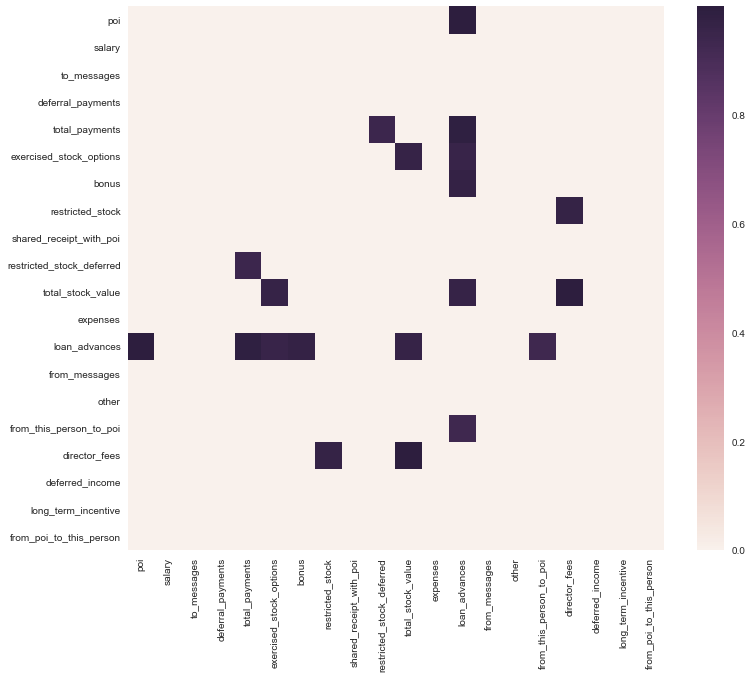

In [9]:
def map_(x):
    if abs(x)==1:
        return 0
    elif abs(x)>0.9:
        return x
    return 0
plt.figure(figsize=(12, 10))
sns.heatmap(abs(corr.applymap(map_)), 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In [10]:
def extract_parameters_by_correlation(corr, min_corr, depth, selections):
    features = corr.columns.values.tolist()
    new_selections = []
    for sel in selections:
        for f in features:
            if (sel != f) and (f not in selections+new_selections) and (f in corr) and (abs(corr[sel][f]) > min_corr):
                new_selections.append(f)
    selections = selections+new_selections
    if depth < 1:
        return selections
    else:
        return extract_parameters_by_correlation(corr, min_corr, depth-1, selections)

In [11]:
primary_components = extract_parameters_by_correlation(corr, 0.9,1, ["poi"])
primary_components

['poi',
 'loan_advances',
 'deferral_payments',
 'total_payments',
 'exercised_stock_options',
 'bonus',
 'restricted_stock',
 'total_stock_value',
 'other',
 'from_this_person_to_poi',
 'deferred_income',
 'long_term_incentive']

In [12]:
# remove NaNs from train data:
def clean_train_data(features):
    for line in features:
        for i,v in enumerate(line):
            if np.isnan(v):
                line[i] = -1.0
    return features

In [13]:
def predict_na_values(df, column):
    print("Predicting missing values for {}.".format(column)) 
    columns = df.columns.values.tolist()
    columns.remove(column)
    # do not translate poi info into missing variables
    columns.remove("poi")
    ok = df[df[column].notnull()]
    ok_features = clean_train_data(ok[columns].values.tolist())
    ok_labels = ok[column].values.tolist()
    nok = df[df[column].isnull()]
    if len(nok)<1:
        print("No missing values for {}!".format(column))
        return
    clf_g = GaussianNB()
    clf_g.fit(ok_features,ok_labels)
    nok_features = clean_train_data(nok[columns].values.tolist())
    pred = clf_g.predict(nok_features)
    df.loc[nok.index,column] = pred

In [14]:
### Fill missing fields with predictions
for column in df.columns.values.tolist():
    ## Do not predict poi 
    if column != "poi":
        predict_na_values(df, column)

Predicting missing values for salary.
Predicting missing values for to_messages.
Predicting missing values for deferral_payments.
Predicting missing values for total_payments.
Predicting missing values for exercised_stock_options.
Predicting missing values for bonus.
Predicting missing values for restricted_stock.
Predicting missing values for shared_receipt_with_poi.
Predicting missing values for restricted_stock_deferred.
Predicting missing values for total_stock_value.
Predicting missing values for expenses.
Predicting missing values for loan_advances.
Predicting missing values for from_messages.
Predicting missing values for other.
Predicting missing values for from_this_person_to_poi.
Predicting missing values for director_fees.
Predicting missing values for deferred_income.
Predicting missing values for long_term_incentive.
Predicting missing values for from_poi_to_this_person.


In [15]:
### Task 3: Create new feature(s)
### Store to my_dataset for easy export below.

# Create new feaures
df['from_poi_ratio'] = df['from_poi_to_this_person']/df['to_messages']
df['to_poi_ratio'] = df['from_this_person_to_poi']/df['from_messages']

my_dataset = df.to_dict(orient='index')
final_feature_list = primary_components+['from_poi_ratio','to_poi_ratio']
#final_feature_list = features_list + ['from_poi_ratio', 'to_poi_ratio']

## parameters weigths extracted from full set
#final_feature_list = ["poi","from_poi_ratio","total_stock_value","bonus","shared_receipt_with_poi","to_messages","restricted_stock"]
### Extract features and labels from dataset for local testing
data = featureFormat(my_dataset, final_feature_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

In [16]:
### Task 4: Try a varity of classifiers
### Please name your classifier clf for easy export below.
### Note that if you want to do PCA or other multi-stage operations,
### you'll need to use Pipelines. For more info:
### http://scikit-learn.org/stable/modules/pipeline.html

# Provided to give you a starting point. Try a variety of classifiers.
clf_g = GaussianNB()

In [17]:
from sklearn.linear_model import LinearRegression
clf_ln = LinearRegression()

In [18]:
opts_l = {
    "alpha":[0.6,0.85,0.95,1.0],
    "fit_intercept":[True,False]
}
clf_l = GridSearchCV(Lasso(), opts_l)
#regression.fit(features, labels)
#pd.DataFrame(zip(features_list_,regression.coef_),columns=["name","coef"]).sort(['coef','name'], ascending=[0,1])

In [19]:
from sklearn import svm
opts_s = {
    "C":[0.1,1.0,10.0],
    #"kernel":["linear", "poly", "rbf"]
}
clf_s = GridSearchCV(svm.SVC(),opts_s)

In [20]:
opts_t = {
    "criterion":["gini","entropy"],
    "min_samples_leaf":[1,2,5],
    "min_samples_split":[2,4,10]
}
clf_t = GridSearchCV(DecisionTreeClassifier(random_state=42), opts_t)

In [21]:
opts_f = {
    "criterion":["gini","entropy"],
    "n_estimators":[5,10,30,100,200],
    "min_samples_leaf":[1,2,5],
    "min_samples_split":[2,4,10]
}
clf_f = GridSearchCV(RandomForestClassifier(random_state = 42), opts_f)
#print("Accuracy: {:.2f}% {}".format(model_predictor(clf)*100, (k+1)*5))

In [22]:
### Task 5: Tune your classifier to achieve better than .3 precision and recall 
### using our testing script. Check the tester.py script in the final project
### folder for details on the evaluation method, especially the test_classifier
### function. Because of the small size of the dataset, the script uses
### stratified shuffle split cross validation. For more info: 
### http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedShuffleSplit.html


# Example starting point. Try investigating other evaluation techniques!
from sklearn.model_selection  import train_test_split
features_train, features_test, labels_train, labels_test = \
    train_test_split(features, labels, test_size=0.3, random_state=42)

In [23]:
features_train[0:2]

[array([  2.00000000e+06,   1.02590000e+04,   9.10930000e+04,
          3.07660640e+07,   1.00000000e+06,   1.26027000e+05,
          3.07660640e+07,   2.85600000e+03,   4.00000000e+00,
         -3.00000000e+05,   1.61701100e+06,   4.64088398e-02,
          1.11111111e-01]),
 array([  4.00000000e+05,   7.31220000e+04,   1.10139300e+06,
          1.17551000e+05,   8.00000000e+05,   3.78082000e+05,
          4.95633000e+05,   4.94000000e+02,   4.00000000e+00,
         -4.12500000e+04,   1.75000000e+05,   0.00000000e+00,
          1.21212121e-01])]

In [24]:
labels_train[0:2]

[1.0, 0.0]

selector = SelectKBest(chi2,k=10)
selector.fit(features_train, labels_train)

In [25]:
models = [
    {"name":"GaussianNB","predictor":clf_g},
    {"name":"Linear Regression","predictor":clf_ln},
    {"name":"Lasso","predictor":clf_l},
    {"name":"SVC","predictor":clf_s},
    {"name":"DecisionTreeClassifier","predictor":clf_t},
    {"name":"RandomForestClassifier","predictor":clf_f}
]

### Scores for Linear Models:

clf_g.fit(features_train, labels_train)
clf_ln.fit(features_train, labels_train)
print "GaussianNB score:  {}".format(clf_g.score(features_test, labels_test))
print "Linear Regression score:  {}".format(clf_ln.score(features_test, labels_test))

### Scores for Other Models w/ Grid Search:

In [26]:
def round_pred(x):
    if x>=0.5:
        return 1.0
    return 0.0

In [27]:
def get_scores(predictions,truth):
    true_negatives = 0
    false_negatives = 0
    false_positives = 0
    true_positives = 0
    for prediction, truth in zip(predictions, labels_test):
        p_int = round_pred(prediction)
        if p_int == 0 and truth == 0:
            true_negatives += 1
        elif p_int == 0 and truth == 1:
            false_negatives += 1
        elif p_int == 1 and truth == 0:
            false_positives += 1
        elif p_int == 1 and truth == 1:
            true_positives += 1
        else:
            print "Warning: Found a predicted label not == 0 or 1. value:{}".format(str(prediction))
    total_predictions = true_negatives + false_negatives + false_positives + true_positives
    accuracy = 1.0*(true_positives + true_negatives)/total_predictions
    precision = 1.0*true_positives/(true_positives+false_positives+0.000001)
    recall = 1.0*true_positives/(true_positives+false_negatives+0.000001)
    f1 = 2.0 * true_positives/(2*true_positives + false_positives+false_negatives+0.000001)
    f2 = (1+2.0*2.0) * precision*recall/(4*precision + recall+0.000001)
    return [accuracy, precision, recall, f1, f2]

In [28]:
def model_predictor(classifier):
    classifier.fit(features_train, labels_train)
    y_pred = classifier.predict(features_test)
    accuracy, precision, recall, f1, f2 = get_scores(y_pred,labels_test)
    return [accuracy, precision, recall, f1, f2]

In [29]:
def run_predictors():
    params = {}
    scores = []
    for predictor in models:
        accuracy, precision, recall, f1, f2 = model_predictor(predictor["predictor"])
        scores.append([predictor["name"], accuracy, precision, recall, f1, f2])
        # print("{} accuracy: {:.2f}, precision: {:.2f}, recall: {:.2f}, F1: {:.2f}, F2: {:.2f}".format(predictor["name"], accuracy, precision, recall, f1, f2))
        if hasattr(predictor["predictor"],"best_estimator_"):
            params[predictor["name"]] = predictor["predictor"].best_estimator_
        else:
            params[predictor["name"]] = predictor["predictor"]
        score_table = pd.DataFrame(scores, columns=["Classifier", "Accuracy", "Precision", "Recall", "F1 Score", "F2 Score"])
    return params, score_table

In [30]:
params, score_table = run_predictors()
score_table

C:\ProgramData\Anaconda2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


,Classifier,Accuracy,Precision,Recall,F1 Score,F2 Score
0,GaussianNB,0.863636,0.250000,0.25,0.250000,0.250000
1,Linear Regression,0.886364,0.333333,0.25,0.285714,0.263158
2,Lasso,0.909091,0.500000,0.25,0.333333,0.277778
3,SVC,0.909091,0.000000,0.00,0.000000,0.000000
4,DecisionTreeClassifier,0.954545,1.000000,0.50,0.666667,0.555555
5,RandomForestClassifier,0.931818,0.999999,0.25,0.400000,0.294117


In [31]:
def pandas_df_to_markdown_table(df):
    from IPython.display import Markdown, display
    fmt = ['---' for i in range(len(df.columns))]
    df_fmt = pd.DataFrame([fmt], columns=df.columns)
    df_formatted = pd.concat([df_fmt, df])
    return df_formatted.to_csv(sep="|", index=False)

### Best Parameters:

In [32]:
params["DecisionTreeClassifier"]

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best')

In [33]:
from operator import itemgetter
weights = zip(final_feature_list,params["DecisionTreeClassifier"].feature_importances_)
weights_df = pd.DataFrame(sorted(weights, key=itemgetter(1), reverse=True), columns=["Parameter", "Weight"])
weights_df[weights_df["Weight"]>0]

,Parameter,Weight
0,from_poi_ratio,0.278774
1,total_stock_value,0.263039
2,exercised_stock_options,0.174847
3,loan_advances,0.088824
4,other,0.069320
5,from_this_person_to_poi,0.063640
6,bonus,0.061556


In [37]:
clf = DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
    max_features=None, max_leaf_nodes=None,
    min_impurity_split=1e-07, min_samples_leaf=1,
    min_samples_split=2, min_weight_fraction_leaf=0.0,
    presort=False, random_state=42, splitter='best')

In [38]:
### Task 6: Dump your classifier, dataset, and features_list so anyone can
### check your results. You do not need to change anything below, but make sure
### that the version of poi_id.py that you submit can be run on its own and
### generates the necessary .pkl files for validating your results.

dump_classifier_and_data(clf, my_dataset, final_feature_list)

In [39]:
# %load tester.py
#!/usr/bin/pickle

""" a basic script for importing student's POI identifier,
    and checking the results that they get from it 
 
    requires that the algorithm, dataset, and features list
    be written to my_classifier.pkl, my_dataset.pkl, and
    my_feature_list.pkl, respectively

    that process should happen at the end of poi_id.py
"""

import pickle
import sys
from sklearn.cross_validation import StratifiedShuffleSplit
sys.path.append("../tools/")
from feature_format import featureFormat, targetFeatureSplit

PERF_FORMAT_STRING = "\
\tAccuracy: {:>0.{display_precision}f}\tPrecision: {:>0.{display_precision}f}\t\
Recall: {:>0.{display_precision}f}\tF1: {:>0.{display_precision}f}\tF2: {:>0.{display_precision}f}"
RESULTS_FORMAT_STRING = "\tTotal predictions: {:4d}\tTrue positives: {:4d}\tFalse positives: {:4d}\
\tFalse negatives: {:4d}\tTrue negatives: {:4d}"

def test_classifier(clf, dataset, feature_list, folds = 1000):
    data = featureFormat(dataset, feature_list, sort_keys = True)
    labels, features = targetFeatureSplit(data)
    cv = StratifiedShuffleSplit(labels, folds, random_state = 42)
    true_negatives = 0
    false_negatives = 0
    true_positives = 0
    false_positives = 0
    for train_idx, test_idx in cv: 
        features_train = []
        features_test  = []
        labels_train   = []
        labels_test    = []
        for ii in train_idx:
            features_train.append( features[ii] )
            labels_train.append( labels[ii] )
        for jj in test_idx:
            features_test.append( features[jj] )
            labels_test.append( labels[jj] )
        
        ### fit the classifier using training set, and test on test set
        clf.fit(features_train, labels_train)
        predictions = clf.predict(features_test)
        for prediction, truth in zip(predictions, labels_test):
            if prediction == 0 and truth == 0:
                true_negatives += 1
            elif prediction == 0 and truth == 1:
                false_negatives += 1
            elif prediction == 1 and truth == 0:
                false_positives += 1
            elif prediction == 1 and truth == 1:
                true_positives += 1
            else:
                print "Warning: Found a predicted label not == 0 or 1."
                print "All predictions should take value 0 or 1."
                print "Evaluating performance for processed predictions:"
                break
    try:
        total_predictions = true_negatives + false_negatives + false_positives + true_positives
        accuracy = 1.0*(true_positives + true_negatives)/total_predictions
        precision = 1.0*true_positives/(true_positives+false_positives)
        recall = 1.0*true_positives/(true_positives+false_negatives)
        f1 = 2.0 * true_positives/(2*true_positives + false_positives+false_negatives)
        f2 = (1+2.0*2.0) * precision*recall/(4*precision + recall)
        print clf
        print PERF_FORMAT_STRING.format(accuracy, precision, recall, f1, f2, display_precision = 5)
        print RESULTS_FORMAT_STRING.format(total_predictions, true_positives, false_positives, false_negatives, true_negatives)
        print ""
    except:
        print "Got a divide by zero when trying out:", clf
        print "Precision or recall may be undefined due to a lack of true positive predicitons."

CLF_PICKLE_FILENAME = "my_classifier.pkl"
DATASET_PICKLE_FILENAME = "my_dataset.pkl"
FEATURE_LIST_FILENAME = "my_feature_list.pkl"

def dump_classifier_and_data(clf, dataset, feature_list):
    with open(CLF_PICKLE_FILENAME, "w") as clf_outfile:
        pickle.dump(clf, clf_outfile)
    with open(DATASET_PICKLE_FILENAME, "w") as dataset_outfile:
        pickle.dump(dataset, dataset_outfile)
    with open(FEATURE_LIST_FILENAME, "w") as featurelist_outfile:
        pickle.dump(feature_list, featurelist_outfile)

def load_classifier_and_data():
    with open(CLF_PICKLE_FILENAME, "r") as clf_infile:
        clf = pickle.load(clf_infile)
    with open(DATASET_PICKLE_FILENAME, "r") as dataset_infile:
        dataset = pickle.load(dataset_infile)
    with open(FEATURE_LIST_FILENAME, "r") as featurelist_infile:
        feature_list = pickle.load(featurelist_infile)
    return clf, dataset, feature_list

def main():
    ### load up student's classifier, dataset, and feature_list
    clf, dataset, feature_list = load_classifier_and_data()
    ### Run testing script
    test_classifier(clf, dataset, feature_list)

if __name__ == '__main__':
    main()


DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best')
	Accuracy: 0.85860	Precision: 0.46468	Recall: 0.39800	F1: 0.42876	F2: 0.40976
	Total predictions: 15000	True positives:  796	False positives:  917	False negatives: 1204	True negatives: 12083

